#CS 6375 - Project - Stock Prediction using RNN

## Submitted By -

## Chetan Siddappareddy - CXS210033

## Lakshmi Sailaja Mandadi - LXM210026

## Lakshmi Saieesha Bonthala - LXB210017

Dataset - Yahoo finance IBM dataset from dec 31 1998 to Aug 1 2022

Dataset link - https://personal.utdallas.edu/~lxm210026/IBM_stock_price.csv

Packages used:
1. numpy 
2. pandas
3. matplotlib.pyplot
4. seaborn 
5. math 
6. sklearn.preprocessing 
7. sklearn.metrics 
 

##Importing Libraries


In [9]:
import pandas 
import numpy 
from math import sqrt
import matplotlib.pyplot as matpyplt
import seaborn as sbrn
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import  r2_score,mean_squared_error,mean_absolute_error

##RNN Class Implementation

Success - Loaded Data

Data Description: Rows - 5934, Columns - 7 .

Data Preview:

             Date        Open        High         Low       Close   Adj Close  \
0     1998-12-31   89.268639   89.477776   87.715103   88.133362   51.915520   
1     1999-01-04   88.432121   89.149139   86.759079   87.476097   51.528339   
2     1999-01-05   87.476097   90.762428   87.386475   90.642921   53.393753   
3     1999-01-06   90.971558   92.136711   90.105164   90.224663   53.147411   
4     1999-01-07   89.836281   91.957458   89.388145   90.911804   53.552177   
...          ...         ...         ...         ...         ...         ...   
5929  2022-07-26  128.259995  129.300003  127.629997  128.080002  128.080002   
5930  2022-07-27  127.970001  129.429993  127.580002  129.119995  129.119995   
5931  2022-07-28  128.750000  129.809998  128.610001  129.220001  129.220001   
5932  2022-07-29  129.520004  131.000000  129.309998  130.789993  130.789993   
5933  2022-08-01  130.750000  132.6

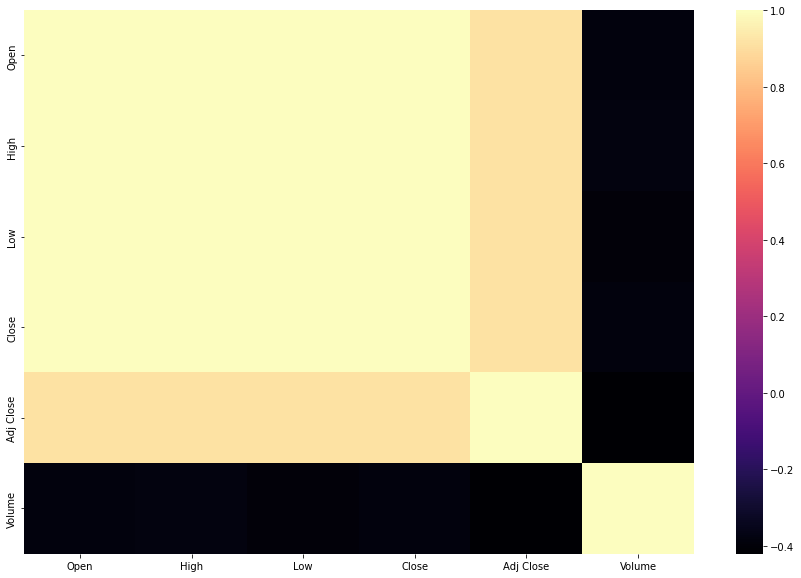

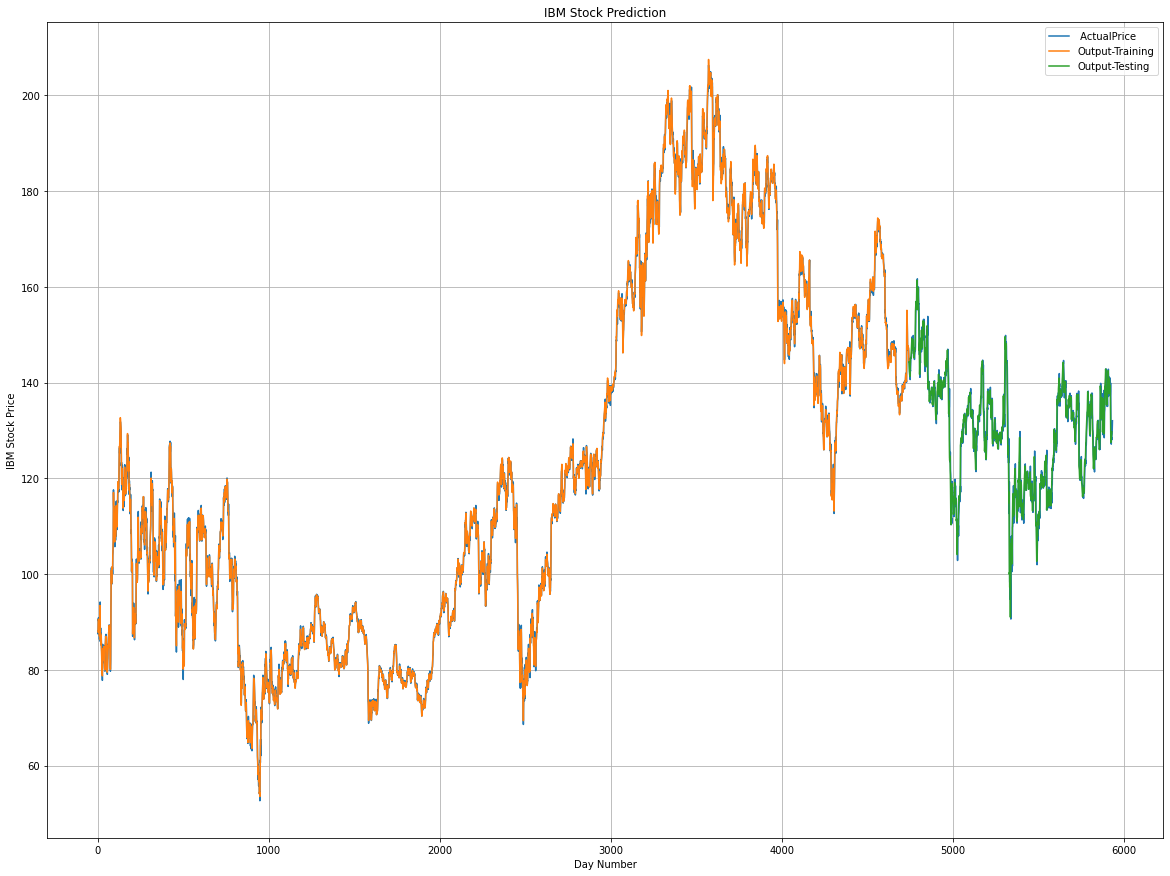

In [14]:
class RNN_timeseries:
    
    
    # Loading Input Raw Data from given URL 
    def __init__(self, inputRawDataFile):
        self.inputData = pandas.DataFrame(pandas.read_csv(inputRawDataFile))

        print("Success - Loaded Data\n")
        print("Data Description: Rows - {}, Columns - {} .\n".format(*self.inputData.shape))
        print("Data Preview:\n\n", self.inputData)

    
    # Data Preprocessing
    def datapreprocess(self):

        print("Data doesn't have null values.\n" if self.inputData.isnull().sum().sum() == 0 else "Data has null values\n")
        print("No Duplicates.\n" if self.inputData.duplicated().sum() == 0 else "Duplicates are present in data\n")
        print(self.inputData.dtypes) 


        # Exploratory Data Analysis 
        print("\nCorrelation Matrix:\n")
        print(self.inputData.corr())
        matpyplt.figure(figsize = (15, 10))
        svm = sbrn.heatmap(self.inputData.corr(), cmap = "magma")
        


        #All attributes are highly correlated
        #Selected one attribute: Close
        self.inputData = self.inputData.drop(["Date", "Open", "Adj Close", "High", "Low", "Volume"], axis = 1)
        print("\nStock Market Close Data(to be used):\n")
        print(self.inputData.head())


        #Data Normalisation
        self.mmScalar = MinMaxScaler()
        self.normalisedData = self.mmScalar.fit_transform(self.inputData)


    #Data Splitting for training and testing
    def SplitData(self, inputSplitRatio = 0.80):   
        # inputSplitRatio of 0.80 implies Training data is 80% and Testing data is 20% by default
        self.X_train = []
        self.Y_train = []
        self.X_test = []
        self.Y_test = []

        SplitLastIndex = round((len(self.normalisedData) - 1) * inputSplitRatio)
  
        # X Training data: [Stock Price 2 days ago, Stock Price 1 day ago]
        for i in range(2, SplitLastIndex):
            tempdata = [self.normalisedData[i - 2], self.normalisedData[i - 1]]
            self.X_train.append(tempdata)

        # Y_train
        # Target: Price on the following day for the given data
        for j in self.normalisedData[2 : SplitLastIndex]:
            self.Y_train.append(j)

        # X_test
        for k in range(SplitLastIndex + 2, len(self.normalisedData)):
            tempdata = [self.normalisedData[k - 2], self.normalisedData[k - 1]]
            self.X_test.append(tempdata)

        # Y_test
        for item in self.normalisedData[SplitLastIndex + 2 : ]:
            self.Y_test.append(item)

        
        self.X_train = numpy.array(self.X_train)
        self.Y_train = numpy.array(self.Y_train)
        self.X_test = numpy.array(self.X_test)
        self.Y_test = numpy.array(self.Y_test)

        print(self.X_train.shape, self.Y_train.shape, self.X_test.shape, self.Y_test.shape)


    # Activation Functions and Derivatives
    def tanhAct(self, ip, ifDerive = False):
        if( ifDerive == False ):
            return numpy.tanh(ip)
        else:
            return (1 - numpy.square(numpy.tanh(ip)))
    def sigAct(self, ip, ifDerive = False):
        if(ifDerive == False):
            return (1 / (1 + numpy.exp(-ip)))
        else:
            return (numpy.exp(-ip)) / ((numpy.exp(-ip) + 1) ** 2)

    def reLuAct(self, ip, ifDerive = False):
        if(ifDerive == False):
            return numpy.maximum(ip, 0)
        else:
            return (ip > 0)


    # Cost/Loss Function - Mean Squared Error
    def costCalculation(self, iAct, iPred):
        return numpy.mean(numpy.square(iAct - iPred))


    # Forward Pass Function
    def fwdProp(self, inputxData):
        # output hidden states
        fopHStates = []
        fopHStates.append(numpy.zeros((self.hNeurons, 1)))
        
        fwdprpStep = 0
      
        while(fwdprpStep < inputxData.shape[0]):
            wtsSum = (self.ipToHWeights @ inputxData[[fwdprpStep]].T) + (self.hToOpWeights @ fopHStates[-1])
            nxtHidStage = self.actFunc(wtsSum)
            fopHStates.append(nxtHidStage)
            fwdprpStep = fwdprpStep + 1
        foHOutput = self.hToHWeights @ fopHStates[-1]
        
        return fopHStates, foHOutput
    

    #Backward Pass Function
    def bwdProp(self, inputxData, outputyData, hStates, hOutput):

        bwdLoss = self.costCalculation(outputyData, hOutput)
        
        # Weights Initialization
        numpy.random.seed(1200)
        bipToHWeights = numpy.zeros(self.ipToHWeights.shape)
        bHToHWeights = numpy.zeros(self.hToHWeights.shape)
        bHToOpWeights = numpy.zeros(self.hToOpWeights.shape)
        
        
        bErrorSl = numpy.dot(self.hToHWeights.T, bwdLoss)
        
        bHStatesSl = bErrorSl * self.actFunc(hStates[-1], ifDerive = True)
        
        # backward pass
        for bwdprpStep in reversed(range(inputxData.shape[0])):
            
            bTemporary = bHStatesSl @ hStates[bwdprpStep-1].T
            bHToOpWeights = bHToOpWeights + bTemporary
            bTemporary = bHStatesSl @ inputxData[[bwdprpStep-1]]
            bipToHWeights = bipToHWeights + bTemporary

        
        bTemporary = (hOutput - outputyData) @ hStates[-1].T
        bHToHWeights = bHToHWeights + bTemporary

        
        self.ipToHWeights = self.ipToHWeights - self.learn_rate * bipToHWeights
        self.hToHWeights = self.hToHWeights - self.learn_rate * bHToHWeights
        self.hToOpWeights = self.hToOpWeights - self.learn_rate * bHToOpWeights


    # Training Function
    def train_function(self, 
               inputINeurons = 1, 
               inputHNeurons = 10, 
               inputONeurons = 1,
               inputLearn_Rate = 0.01,
               inputActFunc = "TanH",
               inputIters = 100):
  
        self.iNeurons = inputINeurons
        self.hNeurons = inputHNeurons
        self.oNeurons = inputONeurons
        self.learn_rate = inputLearn_Rate
        self.iters = inputIters

        if("TanH" == inputActFunc):
            self.actFunc = self.tanhAct

        if("Sigmoid" == inputActFunc):
            self.actFunc = self.sigAct

        if("Relu" == inputActFunc):
            self.actFunc = self.reLuAct

        
        numpy.random.seed(1200)
        self.ipToHWeights = (numpy.random.uniform(0, 1, (self.hNeurons, self.iNeurons)) / 2)
        self.hToHWeights = (numpy.random.uniform(0, 1, (self.oNeurons, self.hNeurons)) / 2)
        self.hToOpWeights = (numpy.random.uniform(0, 1, (self.hNeurons, self.hNeurons)) / 2)

        #print(self.ipToHWeights.shape, self.hToHWeights.shape, self.hToOpWeights.shape)
        
      
        train_iter = 0
        
        while(train_iter < self.iters):
            if(train_iter == self.iters - 1):
                self.trainingRes = []
                
            #  Forward pass
            for i in range(self.X_train.shape[0]):
                trainHStates, trainHOutput = self.fwdProp(self.X_train[i])
               
                if(train_iter == self.iters - 1):
                    self.trainingRes.append(trainHOutput.tolist()[0])

                # Backward pass
                self.bwdProp(self.X_train[i], self.Y_train[i], trainHStates, trainHOutput)
            
            train_iter = train_iter + 1
        
        self.trainingRes = numpy.array(self.trainingRes).T[0]
        
    
    # Testing Function
    def test_func(self):
        self.testingRes = []
        #  Forward pass
        for j in range(self.X_test.shape[0]):
            testHStates, testHOutput = self.fwdProp(self.X_test[j])

            self.testingRes.append(testHOutput.tolist()[0])
            

        self.testingRes = numpy.array(self.testingRes).T[0]

    
    # Model Evaluation & Plotting result
    def evalModelPerformance(self):
  
        print("\nEvaluation Report:\n")
        self.trainingRes = self.mmScalar.inverse_transform(self.trainingRes.reshape(-1,1))
        self.testingRes = self.mmScalar.inverse_transform(self.testingRes.reshape(-1,1))
        self.Y_train = self.mmScalar.inverse_transform(self.Y_train.reshape(-1,1))
        self.Y_test = self.mmScalar.inverse_transform(self.Y_test.reshape(-1,1))
        
        print("MSE_Train: ", mean_squared_error(self.Y_train, self.trainingRes))
        print("RMSE_Train:", sqrt(mean_squared_error(self.Y_train, self.trainingRes)))
        print("MAE_Train:", mean_absolute_error(self.Y_train, self.trainingRes))
        print("R2_Train:", r2_score(self.Y_train, self.trainingRes))

        print("\nMSE_Test: ", mean_squared_error(self.Y_test, self.testingRes))
        print("RMSE_Test:", sqrt(mean_squared_error(self.Y_test, self.testingRes)))
        print("MAE_Test:", mean_absolute_error(self.Y_test, self.testingRes))
        print("R2_Test :", r2_score(self.Y_test, self.testingRes))
        
        
        #Plotting the Results
        matpyplt.figure(figsize = (20, 15))
        matpyplt.xlabel("Day Number")
        matpyplt.ylabel("IBM Stock Price")
        matpyplt.title("IBM Stock Prediction")
       
        matpyplt.plot(self.inputData, label = " ActualPrice")
        matpyplt.plot(self.trainingRes, label = "Output-Training")
        self.testingRes = [i for i in self.testingRes]
        self.testingRes.insert(0, self.trainingRes[-1])
        matpyplt.plot([j for j in range(len(self.trainingRes) - 1, 
                                                        len(self.trainingRes) + len(self.testingRes) - 1)], 
                    self.testingRes, 
                    label = "Output-Testing")
      
        matpyplt.legend()
        matpyplt.grid()
       
       

if __name__ == "__main__":
    IBM_RNN = RNN_timeseries("https://personal.utdallas.edu/~lxm210026/IBM_stock_price.csv")
    IBM_RNN.datapreprocess()
    IBM_RNN.SplitData(0.80)
    IBM_RNN.train_function(inputHNeurons=20, inputONeurons=1, inputLearn_Rate=0.015, inputActFunc="Relu", inputIters=100)
    IBM_RNN.test_func()
    IBM_RNN.evalModelPerformance()
